# OpenPIV tutorial 1


In this tutorial we read a pair of images and perform the PIV using a standard algorithm. At the end, the velocity vector field is plotted.

In [10]:
from openpiv import tools, pyprocess, validation, filters, scaling 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio

### Reading images: 
The images can be read using the `imread` function, and diplayed with matplotlib. 


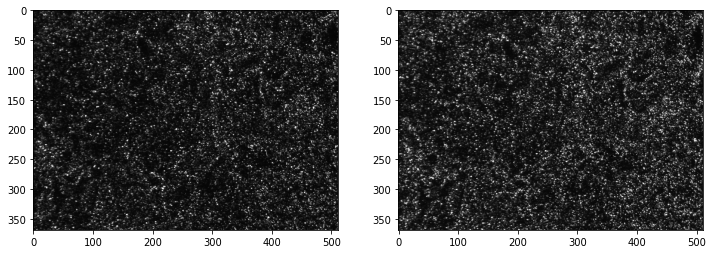

In [11]:
frame_a  = tools.imread( '../../examples/test1/exp1_001_a.bmp' )
frame_b  = tools.imread( '../../examples/test1/exp1_001_b.bmp' )

fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray);
ax[1].imshow(frame_b,cmap=plt.cm.gray);

### Processing

In this tutorial, we are going to use the `extended_search_area_piv` function, wich is a standard PIV cross-correlation algorithm.

This function allows the search area (`search_area_size`) in the second frame to be larger than the interrogation window in the first frame (`window_size`). Also, the search areas can overlap (`overlap`).


The `extended_search_area_piv` function will return three arrays.
1. The `u` component of the velocity vectors
2. The `v` component of the velocity vectors
3. The signal-to-noise ratio (S2N) of the cross-correlation map of each vector. The higher the S2N of a vector, the higher the probability that its magnitude and direction are correct.

In [12]:
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 38  # pixels, search area size in frame B
overlap = 17 # pixels, 50% overlap
dt = 0.02 # sec, time interval between the two frames

u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frame_a.astype(np.int32), 
    frame_b.astype(np.int32), 
    window_size=winsize, 
    overlap=overlap, 
    dt=dt, 
    search_area_size=searchsize, 
    sig2noise_method='peak2peak',
)

The function `get_coordinates` finds the center of each interrogation window. This will be useful later on when plotting the vector field.

In [13]:
x, y = pyprocess.get_coordinates( 
    image_size=frame_a.shape, 
    search_area_size=searchsize, 
    overlap=overlap,
)

### Post-processing

Strictly speaking, we are ready to plot the vector field. But before we do that, we can perform some convenient pos-processing.

To start, lets use the function `sig2noise_val` to get a mask indicating which vectors have a minimum amount of S2N. Vectors below a certain threshold are substituted by `NaN`. If you are not sure about which threshold value to use, try taking a look at the S2N histogram with:

`plt.hist(sig2noise.flatten())`

In [14]:
u1, v1, mask = validation.sig2noise_val( 
    u0, v0, 
    sig2noise, 
    threshold = 1.05,
)

Another useful function is `replace_outliers`, which will find outlier vectors, and substitute them by an average of neighboring vectors. The larger the `kernel_size` the larger is the considered neighborhood. This function uses an iterative image inpainting algorithm. The amount of iterations can be chosen via `max_iter`.

In [15]:
u2, v2 = filters.replace_outliers( 
    u1, v1,
    method='localmean', 
    max_iter=3, 
    kernel_size=3,
)

Next, we are going to convert pixels to millimeters, and flip the coordinate system such that the origin becomes the bottom left corner of the image.

In [16]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(
    x, y, u2, v2, 
    scaling_factor = 96.52,  # 96.52 pixels/millimeter
)

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

### Results

The function `save` is used to save the vector field to a ASCII tabular file. The coordinates and S2N mask are also saved.

In [17]:
tools.save(x, y, u3, v3, mask, 'exp1_001.txt' )

Finally, the vector field can be plotted with `display_vector_field`. 

Vectors with S2N bellow the threshold are displayed in red.

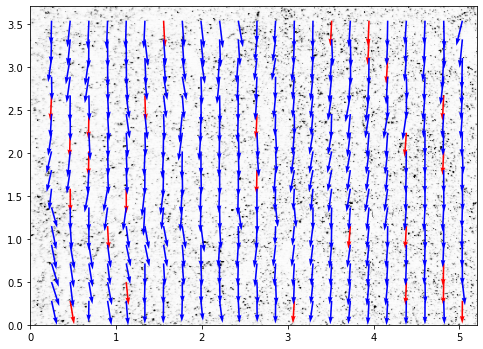

In [18]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field(
    'exp1_001.txt', 
    ax=ax, scaling_factor=96.52, 
    scale=50, # scale defines here the arrow length
    width=0.0035, # width is the thickness of the arrow
    on_img=True, # overlay on the image
    image_name='../../examples/test1/exp1_001_a.bmp',
);